# Test ScatterLightCorrector Class

This notebook shows how to use `ScatterLightCorrector` class to access the scatter light (SL) cube files and evaluate them in a given pixel grid and cadences using to correct the SL background signal of TPFs.

In [4]:
%load_ext autoreload
%autoreload 2

In [61]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u

from tesscube import TESSCube
from tqdm import tqdm
from astropy.stats import median_absolute_deviation as MAD
from astropy.io import fits
from astropy.coordinates import SkyCoord

from tess_backml.corrector import ScatterLightCorrector

In [6]:
# define sector/camera/ccd
sector = 2
camera = 1
ccd = 1
# CCD edges
rmin, rmax = 0, 2048
cmin, cmax = 45, 2093

In [270]:
# help function to do segmentation and labeling in a star mask
def label_mask_segments(mask: np.ndarray) -> np.ndarray:
    """
    Labels connected segments in a 2D boolean mask.

    Parameters
    ----------
    mask : np.ndarray
        A 2D NumPy array of boolean values where True
        indicates a foreground pixel and False indicates
        a background pixel.

    Returns
    -------
    labeled_array: np.ndarray
        A 2D NumPy array of the same shape as the input mask,
        where each connected segment of True values is assigned
        a unique positive integer label. Background pixels (False)
        will have a label of 0.
    """
    if not isinstance(mask, np.ndarray):
        raise TypeError("Input mask must be a NumPy array.")
    if mask.ndim != 2:
        raise ValueError("Input mask must be a 2D array.")
    if mask.dtype != bool:
        # If the mask is not boolean, convert it.
        # This handles cases where the mask might be 0s and 1s.
        mask = mask.astype(bool)

    labeled_array, num_features = label(mask)

    print(f"Found {num_features} distinct segments.")
    return labeled_array

## Get TPFs
We'll use star examples for this Sector/Camera/CCD, here's the TIC catalog 

In [22]:
tics = pd.read_csv(
    f"./data/all_targets_S{sector:03}_v1.csv", skiprows=5
).query(f"Camera == {camera} and CCD == {ccd}").reset_index()
tics

,index,TICID,Camera,CCD,Tmag,RA,Dec
0,298,9156895,1,1,10.20,351.6895,-23.7569
1,302,9163365,1,1,9.68,351.8080,-23.5895
2,303,9163461,1,1,9.53,351.8870,-23.8036
3,304,9163481,1,1,9.41,351.8548,-23.7171
4,567,12881069,1,1,10.21,345.2380,-26.1739
...,...,...,...,...,...,...,...
747,15212,393949845,1,1,10.10,344.7404,-36.4572
748,15213,393949920,1,1,10.83,344.7548,-36.1248
749,15214,393950079,1,1,5.75,345.6416,-36.4207
750,15968,471012252,1,1,10.16,346.9489,-27.9071


We'll use `tesscube` to extract a TPF

In [24]:
tcube = TESSCube(sector=sector, camera=camera, ccd=ccd)

1% (10/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=4).


393949920
INFO:lightkurve.utils:1% (10/1245) of the cadences will be ignored due to the quality mask (quality_bitmask=4).


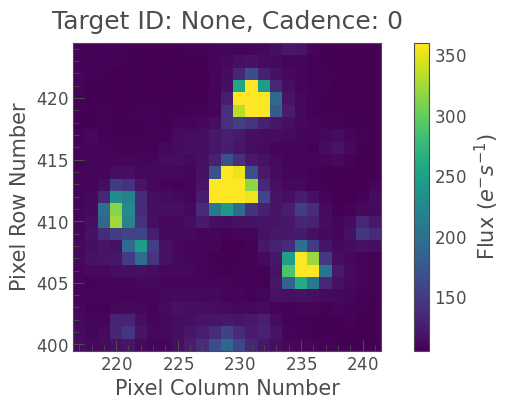

In [274]:
# TIC example
k = 748
print(tics.TICID[k])
# make a TPF around the coordinates
coord = SkyCoord(ra=tics.RA[k] * u.deg, dec=tics.Dec[k] * u.deg)
hdul = tcube.get_tpf(coord, shape=(25, 25))
# remove frames with coarse point
tpf = lk.TessTargetPixelFile(hdul, quality_bitmask=(4))
tpf.plot();

## Corrector
The class internally reads the FITS file that has the downsize version of the SL cube computed from the FFIs.
The FITS fila also has the necessary metadata to describe the downsampling function, binsizes, etc.
We can inspect the FITS file:

In [268]:
fname = f"./data/ffi_sl_cube_sector{sector:03}_{camera}-{ccd}.fits"
hdul = fits.open(fname)
hdul.info()

Filename: ./data/ffi_sl_cube_sector002_1-1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      62   ()      
  1  SCATTER LIGHT CUBE    1 ImageHDU        10   (2, 312, 256, 256)   float32   
  2  PIXEL COUNTS    1 ImageHDU         8   (256, 256)   int64   
  3  TIME          1 BinTableHDU     13   312R x 1C   [D]   


Initialize the corrector object

In [269]:
slcorr = ScatterLightCorrector(sector=sector, camera=camera, ccd=ccd, fname=fname)
slcorr

TESS FFI SL Corrector (Sector, Camera, CCD): 2, 1, 1

The SLCorrector needs the row and column pixels that will be evaluated and the times of observations.
We'll create these using the TPF

In [276]:
# pixel array for evaluation
row_eval = np.arange(tpf.row, tpf.row + tpf.shape[1])
col_eval = np.arange(tpf.column, tpf.column + tpf.shape[2])
# time array for evaluation
time_eval = tpf.time.value + slcorr.btjd0
# evaluate the SL model at given pixel/times
sl_eval = slcorr.evaluate_scatterlight_model(
    row_eval=row_eval, col_eval=col_eval, times=time_eval
)

INFO:tess_backml:time index range [0:312]
INFO:tess_backml:[row,col] range  [48:54, 19:26]


Pixel interp: 100%|██████████| 1235/1235 [00:00<00:00, 17169.77it/s]


Now, we create a mask with every star in the TPF to do aperture photometry.

In [275]:
threshold = 3
# median image
median_image = np.nanmedian(tpf.flux, axis=0)
vals = median_image[np.isfinite(median_image)].flatten()
# compute cut using MAD and assuming gaussianity
mad_cut = (1.4826 * MAD(vals) * threshold) + np.nanmedian(median_image)
# Create a mask containing the pixels above the threshold flux
threshold_mask = np.nan_to_num(median_image) >= mad_cut
# segmentation of stars and background 
stars_mask = label_mask_segments(threshold_mask)

Found 9 distinct segments.


## LC comparison
Let's compare the raw light curve vs the SL corrected ones for the background and a set of stars in the TPF

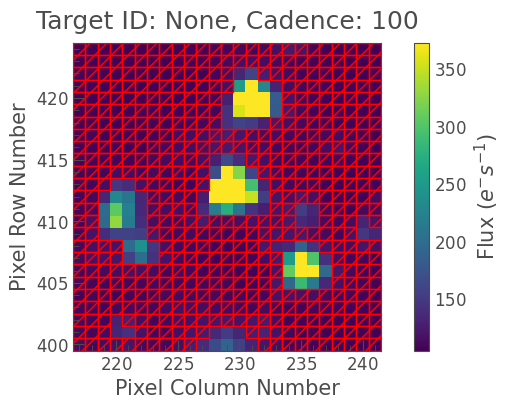

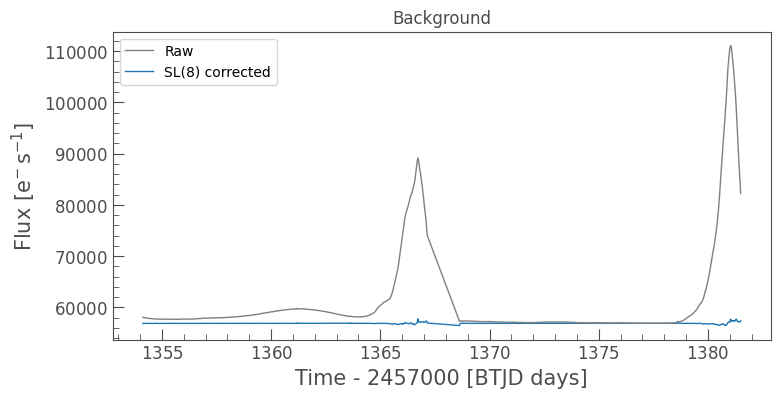

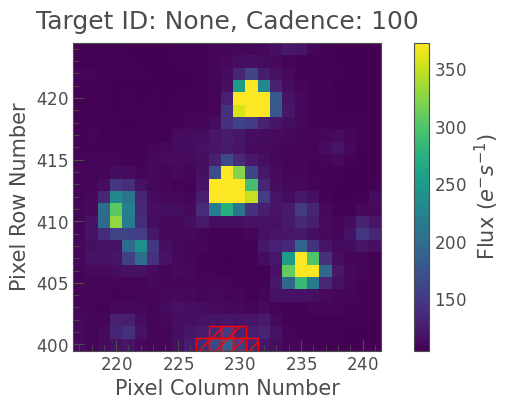

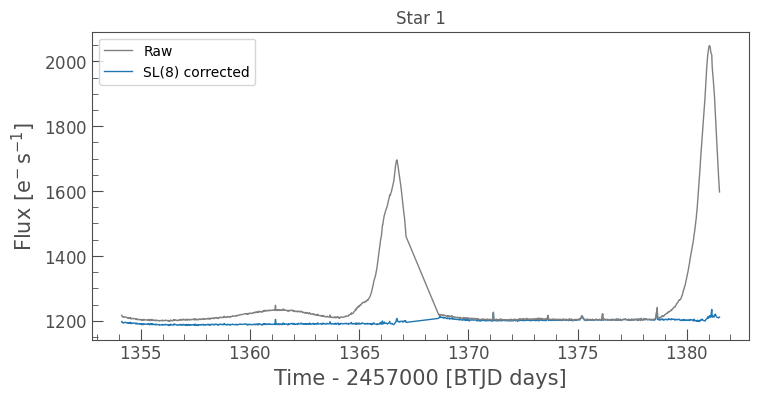

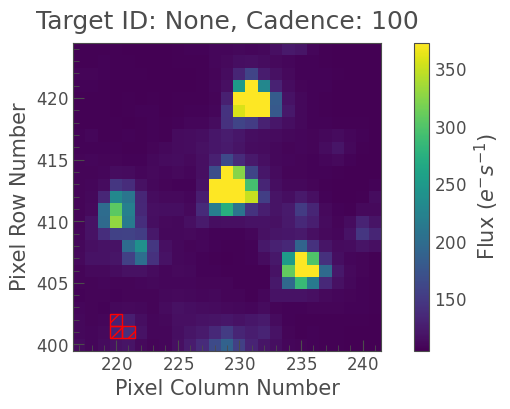

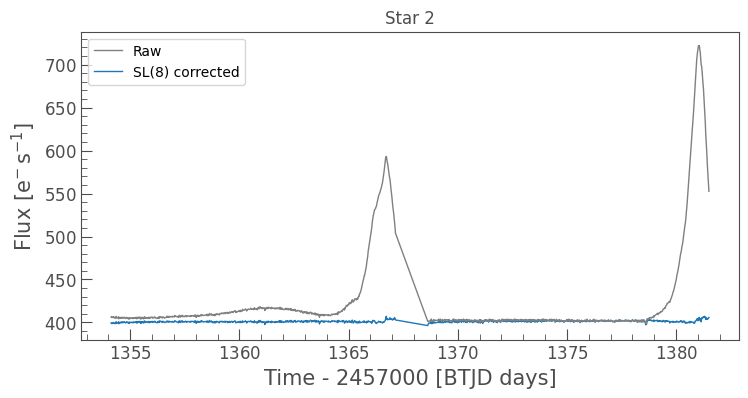

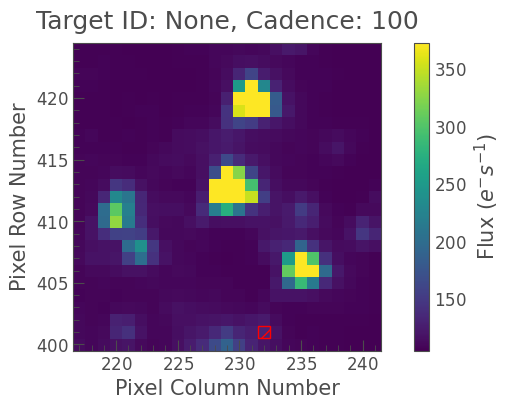

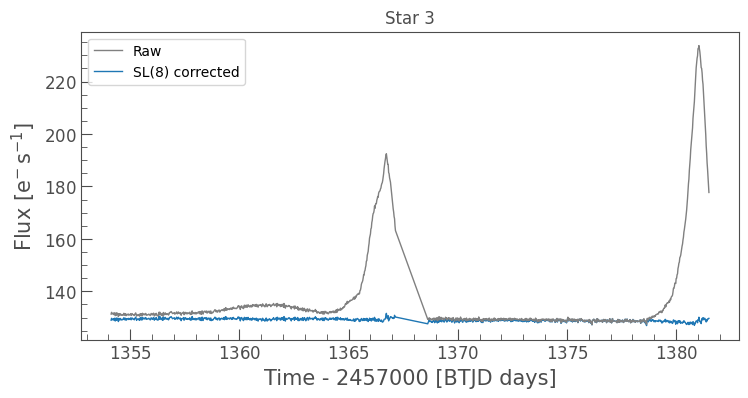

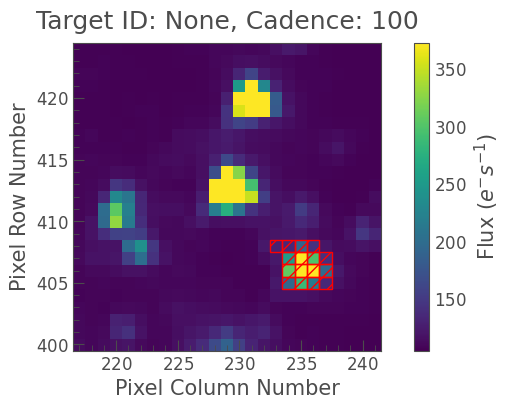

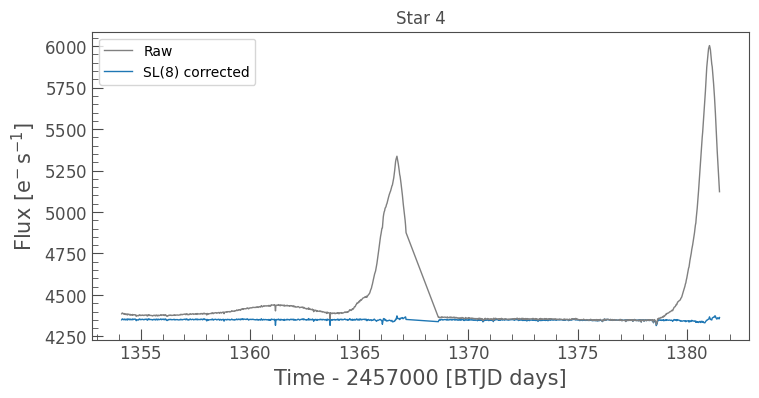

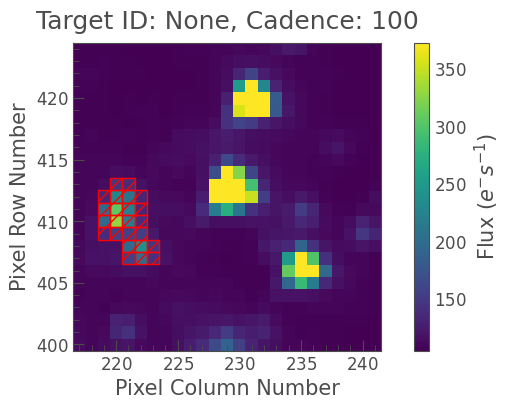

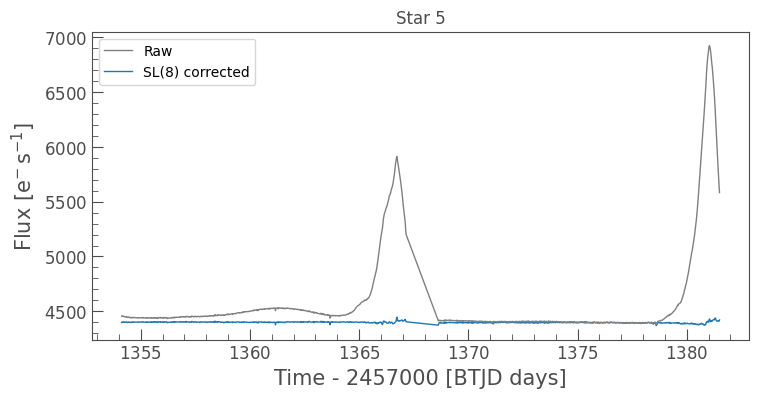

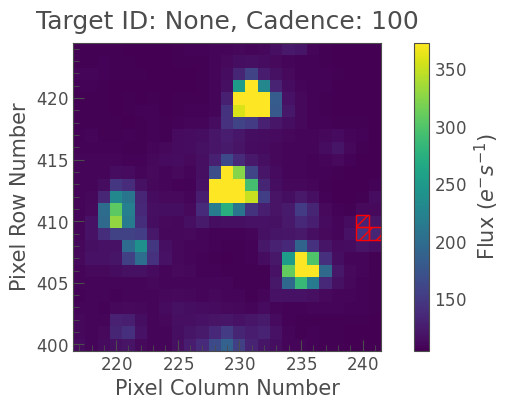

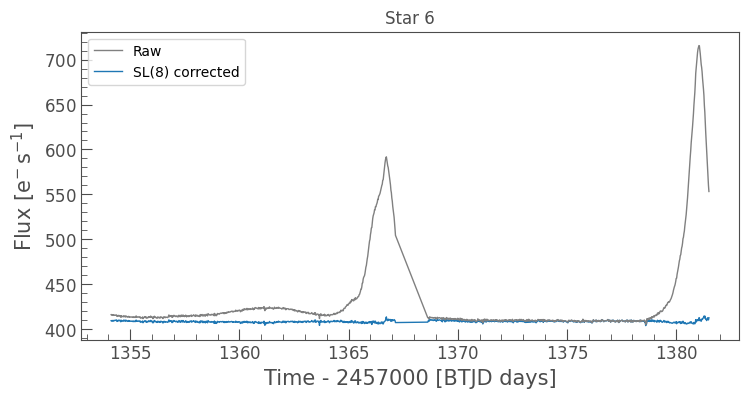

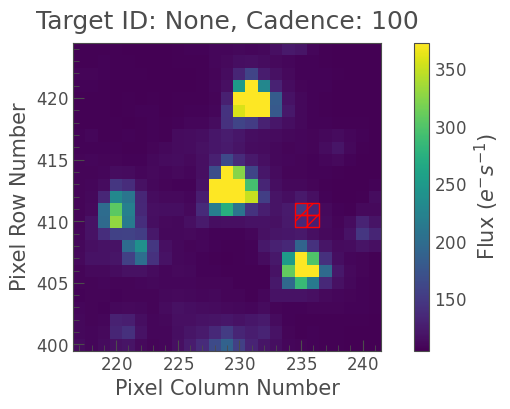

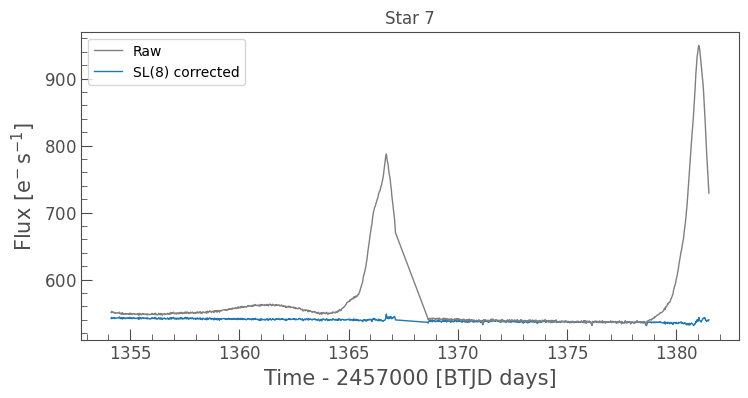

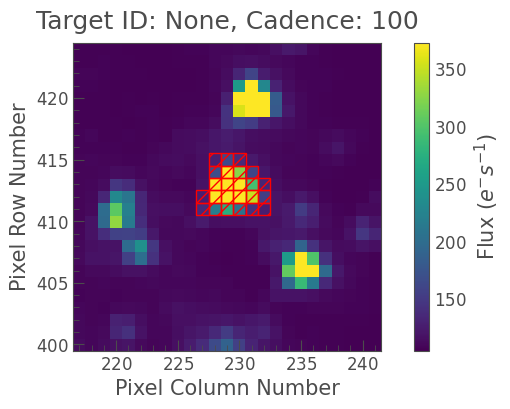

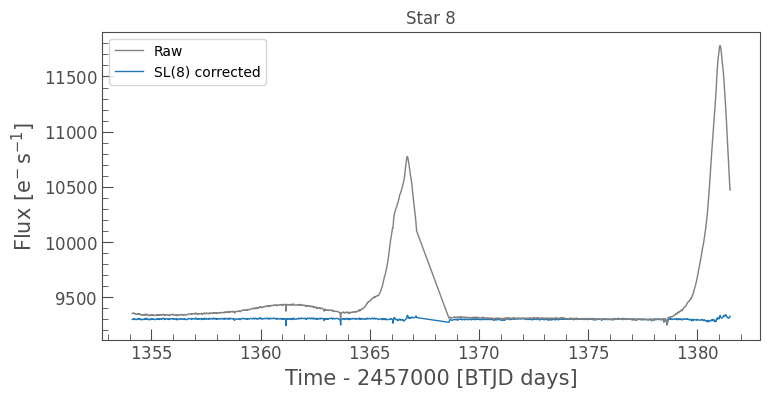

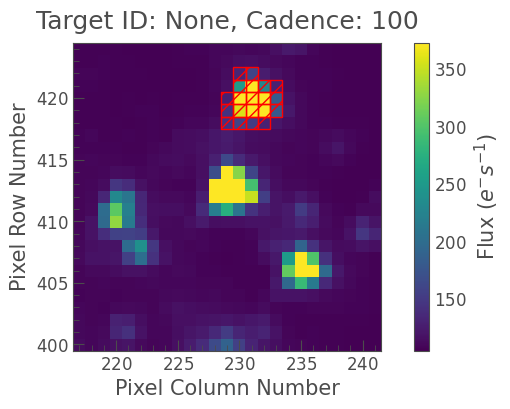

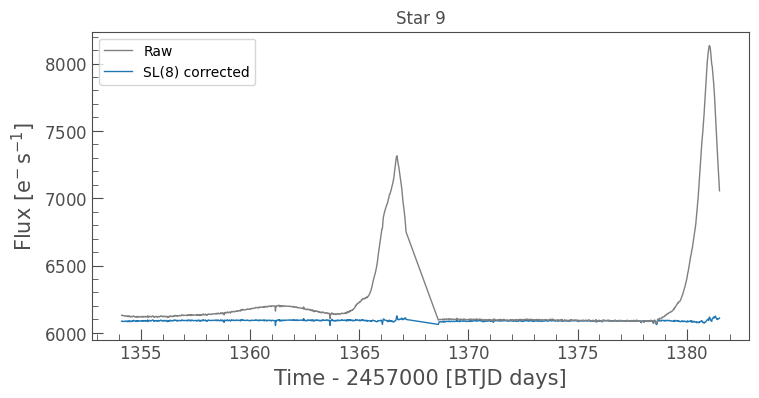

In [277]:
for star in np.unique(stars_mask):
    tpf.plot(cadenceno=100, aperture_mask=stars_mask == star)
    plt.show()
    raw_lc = tpf.extract_aperture_photometry(aperture_mask=stars_mask == star)
    corr_lc = np.nansum((tpf.flux - sl_eval * tpf.flux.unit)[:, stars_mask == star], axis=1)

    ax = raw_lc.plot(label="Raw", lw=1, c="gray")
    ax.plot(raw_lc.time.value, corr_lc, label="SL(8) corrected", zorder=-5000, lw=1, c="tab:blue")
    ax.set_title("Background" if star == 0 else f"Star {star}")
    plt.legend()
    plt.show()
    # break

Wooow!! Those corrected LCs look very flat, the strong SL signal at the end of each TESS orbit is corrected, for all the stars in this TPF.
Let's check out how does this look for "empty" apertures in the background.
We'll create random apertures in the background.

In [278]:
# get 10 random positions in the background
tpf_rows, tpf_cols = np.mgrid[tpf.row: tpf.row + tpf.shape[1], tpf.column: tpf.column + tpf.shape[2]]
bkg_rows = tpf_rows[stars_mask == 0]
bkg_cols = tpf_cols[stars_mask == 0]
r0, c0 = np.random.choice(bkg_rows, size=10), np.random.choice(bkg_cols, size=10)

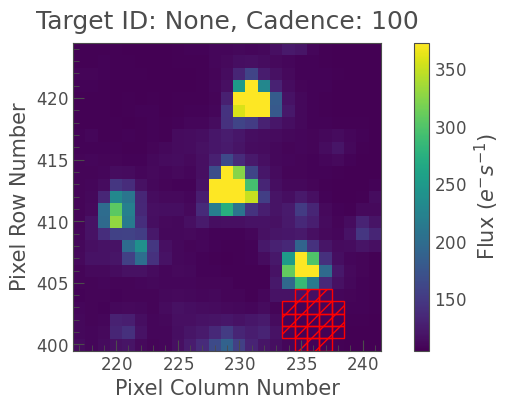

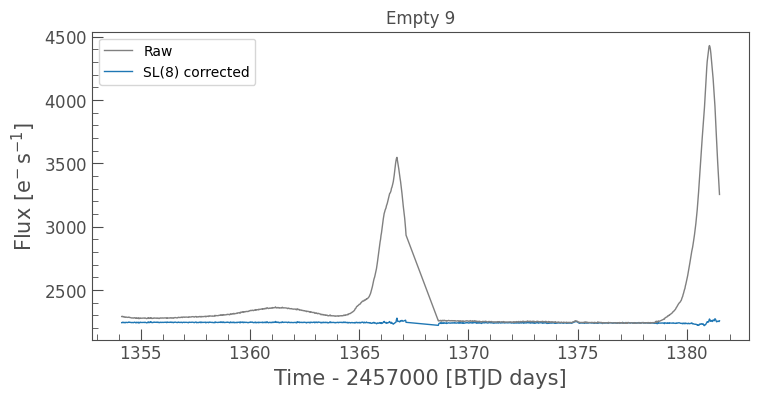

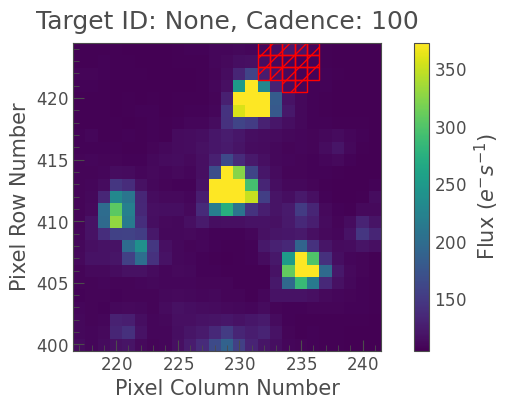

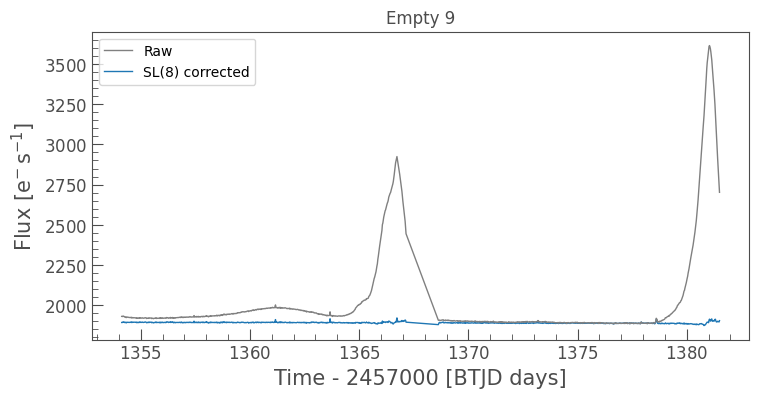

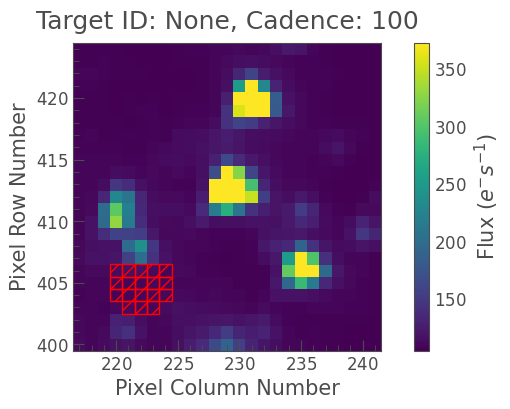

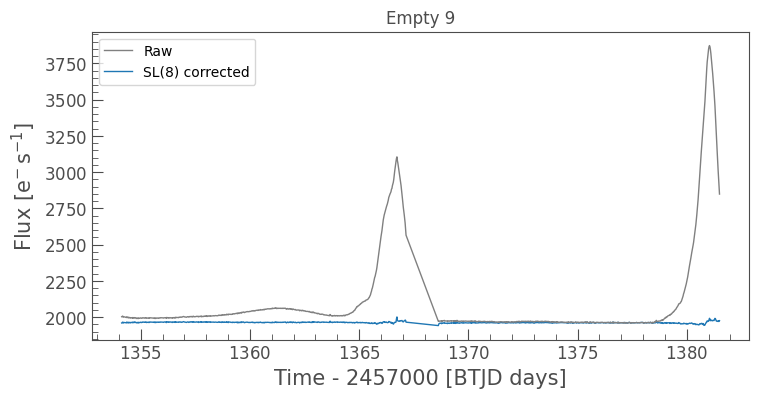

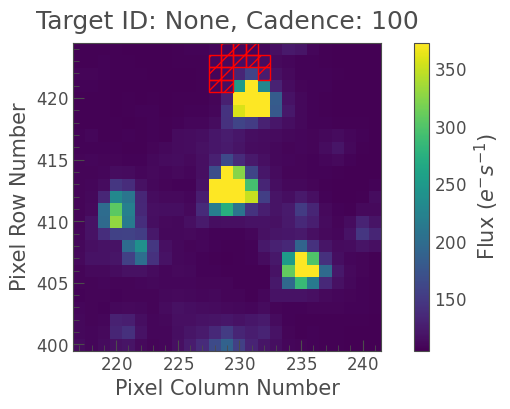

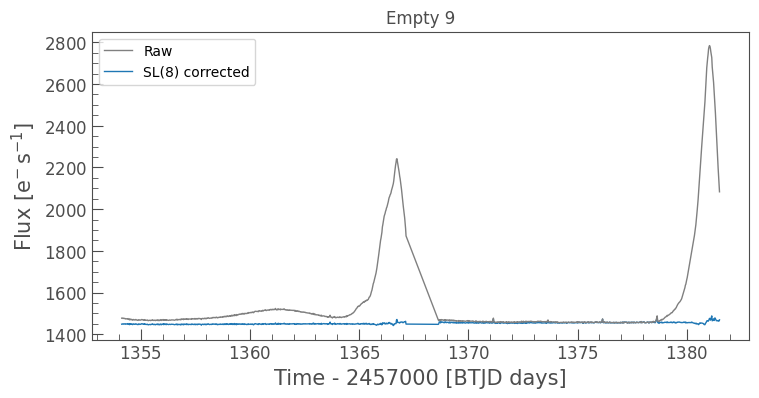

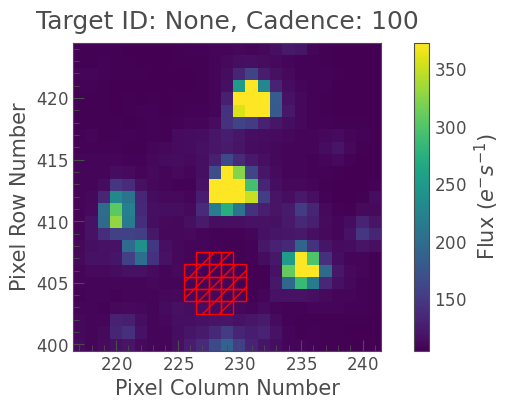

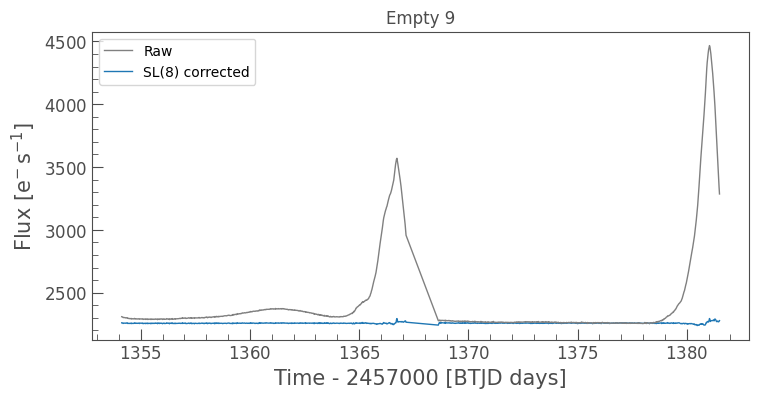

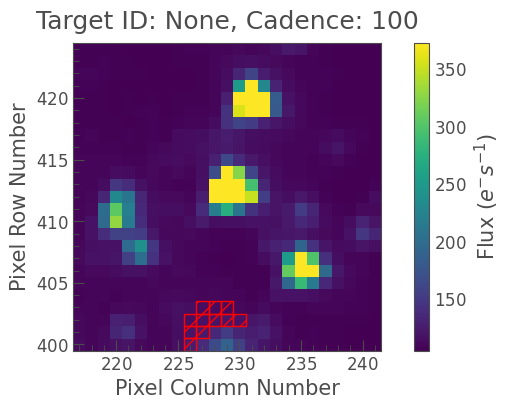

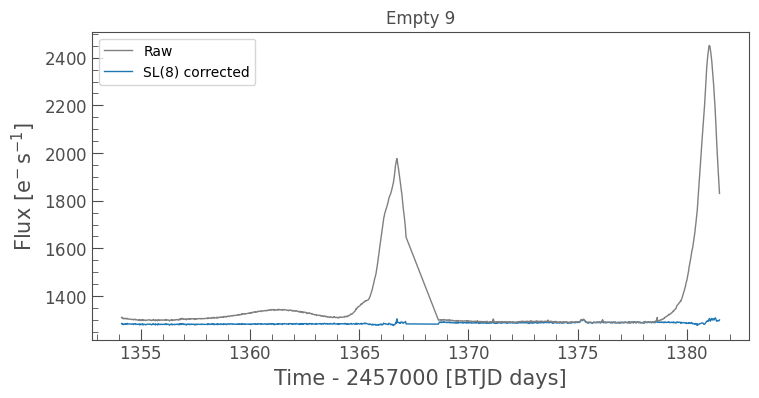

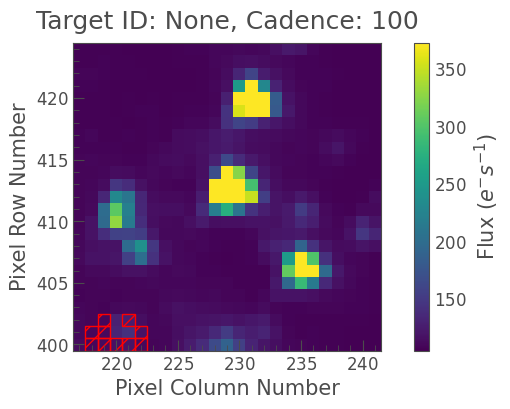

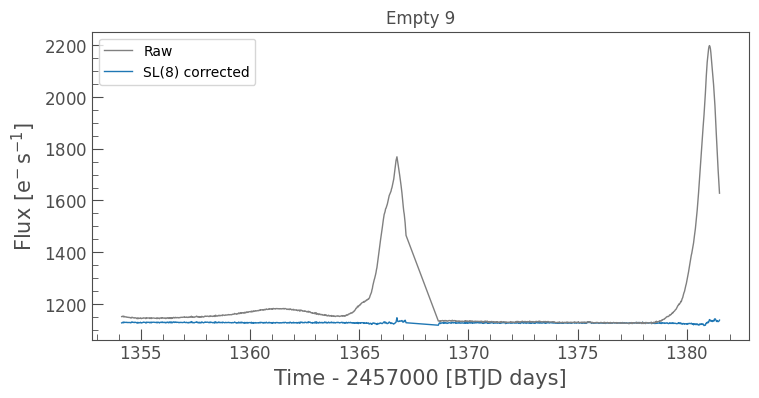

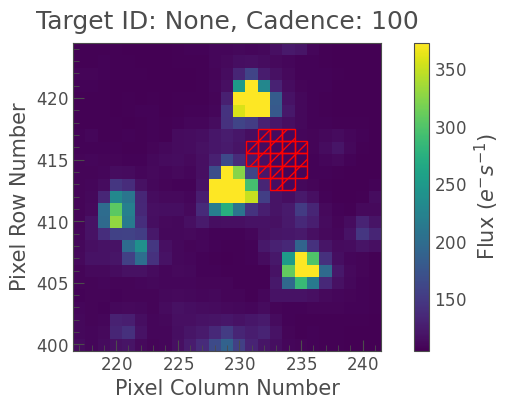

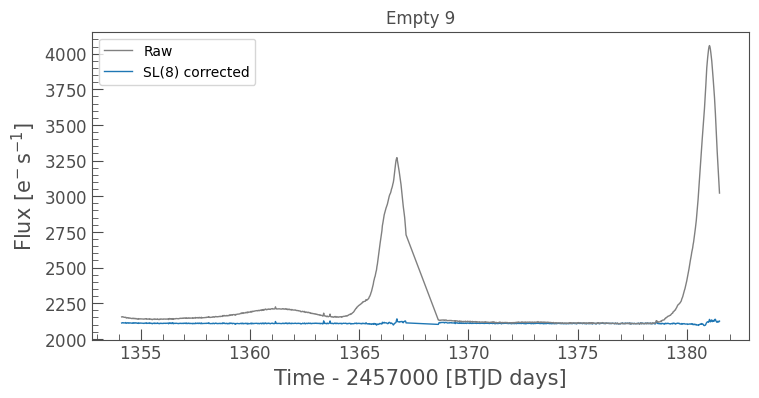

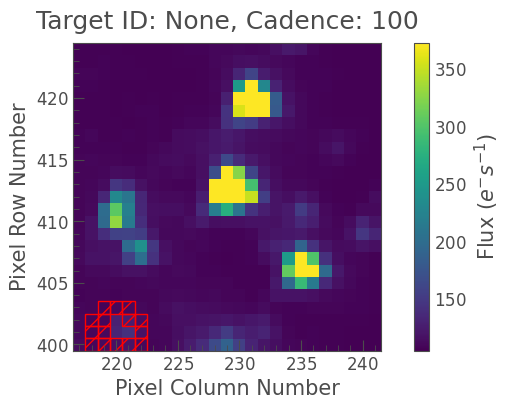

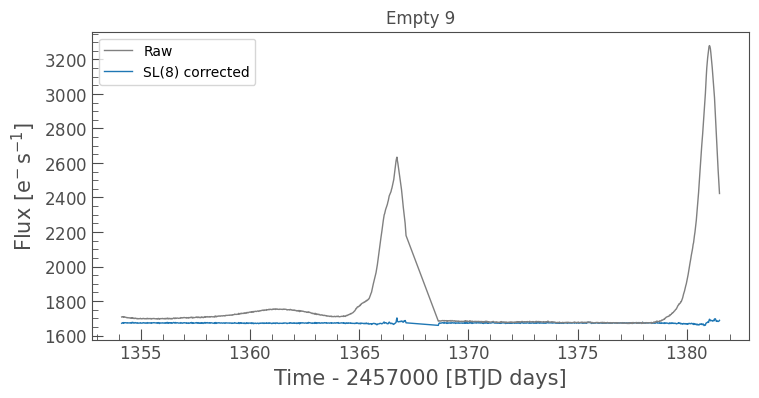

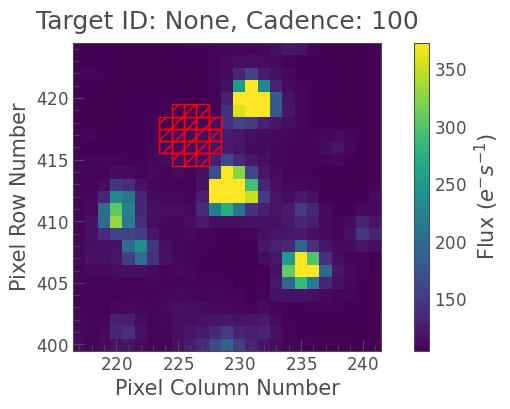

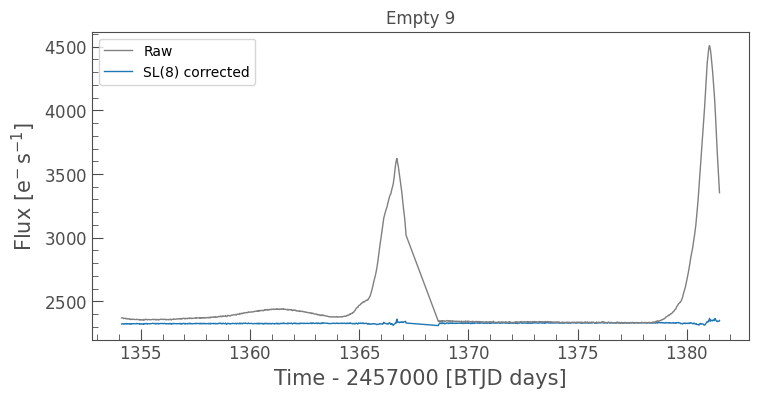

In [280]:
# iterate every position and make a 2.5 rad aperture without star signal
rad = 2.5
for r, c in zip(r0, c0):
    # aperture mask
    empty_ap = (np.sqrt((r - tpf_rows)**2 + (c - tpf_cols)**2) < rad) & (stars_mask == 0)
    tpf.plot(cadenceno=100, aperture_mask=empty_ap)
    plt.show()

    # raw LC
    raw_lc = tpf.extract_aperture_photometry(aperture_mask=empty_ap)
    # corrected LC
    corr_lc = np.nansum((tpf.flux - sl_eval * tpf.flux.unit)[:, empty_ap], axis=1)

    ax = raw_lc.plot(label="Raw", lw=1, c="gray")
    ax.plot(raw_lc.time.value, corr_lc, label="SL(8) corrected", zorder=-5000, lw=1, c="tab:blue")
    ax.set_title("Background" if star == 0 else f"Empty {star}")
    plt.legend()
    plt.show()
    # break